# Project: Kickstarter Project

## Exploring Kickstarter Data and Identifying Key Factors for Project Success

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from patsy import dmatrices
import statsmodels.api as sm;
from datetime import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [25]:
# read in csv
df_og = pd.read_csv('ks-projects-201801.csv')

## Introduction:

## Data Assessment:

In [26]:
# visual assessment
df_og.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


* Does not look like we'll be needing the ID column for analysis
* As usd conversion is already done for us, we won't be needing currency either (we still have country recorded)
* Extract live_time from deadline - launched
* Remove goal as well since we have usd_goal_real
* Discrepancy between usd pledged and usd_pledged_real (Row #2) - We will take usd_pledged_real (converted by fixer.io api) over KS conversions due to errors

In [27]:
df_og.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [28]:
df_og.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

* Naming convention for main cateogy and category is confusing. Rename category as sub_category

In [29]:
df_og.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [30]:
df_og.currency.value_counts()

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [31]:
df_og.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [32]:
string = 'N,0"'
df_no = df_og.query('country == @string')

In [33]:
df_no.tail()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.0,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.0,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.0,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.0,undefined,0,"N,0""",NaN,3273.36,3080.81
378588,999621278,Jeune auteur a besoin de vous!,Publishing,Publishing,EUR,2015-11-20,1600.0,2015-10-21 21:28:13,0.0,undefined,0,"N,0""",NaN,0.00,1710.08


* Fix Typo in Country: N,0"
  * Upon taking a closer look at rows with country listed as "N,0"" and each of the projects on kickstarter.com, there was no single country that all of these projects belonged to. I assume that it is being recorded as NA. Not all hope is lost though, I found that the currency is the perfect indicator as to which country the project belongs to. Therefore, we will need to keep the currency column to fill in N,0"s and drop it later on

In [34]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [35]:
type(df_og.deadline[0])

str

In [36]:
type(df_og.launched[0])

str

* change both deadline and launch date to datetime object

## Wrangling

In [78]:
df = df_og.copy()

In [79]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [80]:
# selecting columns I want to use for analysis
df = df[['name', 'main_category', 'category', 'currency', 'country', 'launched', 'deadline', 'state', 'backers', 'usd_pledged_real', 'usd_goal_real']]

In [81]:
df.head()

,name,main_category,category,currency,country,launched,deadline,state,backers,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Publishing,Poetry,GBP,GB,2015-08-11 12:12:28,2015-10-09,failed,0,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,Narrative Film,USD,US,2017-09-02 04:43:57,2017-11-01,failed,15,2421.0,30000.00
2,Where is Hank?,Film & Video,Narrative Film,USD,US,2013-01-12 00:20:50,2013-02-26,failed,3,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,2012-03-17 03:24:11,2012-04-16,failed,1,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,US,2015-07-04 08:35:03,2015-08-29,canceled,14,1283.0,19500.00


In [82]:
# renaming columns
df.columns = ['name', 'main_cat', 'sub_cat', 'currency', 'country', 'launch_date', 'deadline', 'state', 'backers', 'usd_pledged', 'usd_goal']

In [83]:
df.head()

,name,main_cat,sub_cat,currency,country,launch_date,deadline,state,backers,usd_pledged,usd_goal
0,The Songs of Adelaide & Abullah,Publishing,Poetry,GBP,GB,2015-08-11 12:12:28,2015-10-09,failed,0,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,Narrative Film,USD,US,2017-09-02 04:43:57,2017-11-01,failed,15,2421.0,30000.00
2,Where is Hank?,Film & Video,Narrative Film,USD,US,2013-01-12 00:20:50,2013-02-26,failed,3,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,2012-03-17 03:24:11,2012-04-16,failed,1,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,US,2015-07-04 08:35:03,2015-08-29,canceled,14,1283.0,19500.00


In [84]:
# Converting launch date and deadline to datetime object
df.launch_date = pd.to_datetime(df.launch_date)
df.deadline = pd.to_datetime(df.deadline)

# Creating project live time column by calculating difference between launch and deadline
df['live_days'] = (df.deadline - df.launch_date).apply(lambda x: x/np.timedelta64(1,'D'))

In [85]:
df.head()

,name,main_cat,sub_cat,currency,country,launch_date,deadline,state,backers,usd_pledged,usd_goal,live_days
0,The Songs of Adelaide & Abullah,Publishing,Poetry,GBP,GB,2015-08-11 12:12:28,2015-10-09,failed,0,0.0,1533.95,58.491343
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,Narrative Film,USD,US,2017-09-02 04:43:57,2017-11-01,failed,15,2421.0,30000.00,59.802813
2,Where is Hank?,Film & Video,Narrative Film,USD,US,2013-01-12 00:20:50,2013-02-26,failed,3,220.0,45000.00,44.985532
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,2012-03-17 03:24:11,2012-04-16,failed,1,1.0,5000.00,29.858206
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,US,2015-07-04 08:35:03,2015-08-29,canceled,14,1283.0,19500.00,55.642326


In [86]:
# separate data into 2. One with countries listed as N,0" and the rest so we can fix and concatenate afterwards
df_no = df.query('country == @string')
df = df.query('country != @string')

In [87]:
# taking a look at currencies present 
df_no.currency.value_counts()

USD    2738
GBP     460
CAD     206
EUR     186
AUD     111
SEK      31
NZD      28
DKK      16
NOK      14
CHF       7
Name: currency, dtype: int64

In [88]:
# calculating proportion of countries with EURO as their main currency in df (not df_no)
n_eur = df.query('currency == "EUR"').country.count()
df.query('currency == "EUR"').country.value_counts() / n_eur

DE    0.242232
FR    0.170684
IT    0.167141
NL    0.166560
ES    0.132180
IE    0.047099
BE    0.035833
AT    0.034671
LU    0.003601
Name: country, dtype: float64

In [89]:
print(n_eur)

17219


n = 17,219

Approximate % of countries in each projects using EUR as main currency:

* DE - 24
* FR - 17
* IT - 17
* NL - 17
* ES - 13
* IE - 5
* BE - 3
* AT - 3
* LU - 1

In [90]:
for i in df_no.index:
    # grab currency data
    ccy = df_no.get_value(i, 'currency')
    
    # USA
    if ccy == 'USD':
        df_no.set_value(i, 'country', 'US')
    
    # UK
    elif ccy == 'GBP':
        df_no.set_value(i, 'country', 'UK')
    
    # Canada    
    elif ccy == 'CAD':
        df_no.set_value(i, 'country', 'CA')
    
    # Euros - Since more than 1 country uses EUR, I will distribute each project into a random country following the proportion above
    elif ccy == 'EUR':
        x = np.random.randint(1, 100)
        
        if (x <= 24):
            df_no.set_value(i, 'country', 'DE')
        
        elif (x > 24) & (x <= 41):
            df_no.set_value(i, 'country', 'FR')
        
        elif (x > 41) & (x <= 58):
            df_no.set_value(i, 'country', 'IT')
            
        elif (x > 58) & (x <= 75):
            df_no.set_value(i, 'country', 'NL')
        
        elif (x > 75) & (x <= 88):
            df_no.set_value(i, 'country', 'ES')
        
        elif (x > 88) & (x <= 93):
            df_no.set_value(i, 'country', 'IE')
        
        elif (x > 93) & (x <= 96):
            df_no.set_value(i, 'country', 'BE')
            
        elif (x > 96) & (x <= 99):
            df_no.set_value(i, 'country', 'AT')
            
        elif (x == 100):
            df_no.set_value(i, 'country', 'LU')      
    
    # Australia
    elif ccy == 'AUD':
        df_no.set_value(i, 'country', 'AU')
    
    # Sweden
    elif ccy == 'SEK':
        df_no.set_value(i, 'country', 'SE')
       
    # New Zealand
    elif ccy == 'NZD':
        df_no.set_value(i, 'country', 'NZ')
    
    # Denmark
    elif ccy == 'DKK':
        df_no.set_value(i, 'country', 'DK')
     
    # Norway
    elif ccy == 'NOK':
        df_no.set_value(i, 'country', 'NO')
    
    # Switzerland
    elif ccy == 'CHF':
        df_no.set_value(i, 'country', 'CH')

C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import

In [91]:
df_no.query('currency == "EUR"').country.value_counts()

DE    51
NL    41
FR    31
ES    23
IT    21
IE    11
AT     5
BE     3
Name: country, dtype: int64

Distribution here resembles the bigger sample from df (n = 17,219), which is a great sign!

In [92]:
# concatenate df_no back into df
df = pd.concat([df, df_no], ignore_index = True)

In [93]:
df.tail()

,name,main_cat,sub_cat,currency,country,launch_date,deadline,state,backers,usd_pledged,usd_goal,live_days
378656,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,US,2014-12-05 04:19:14,2015-02-03,undefined,0,10.00,7500.00,59.819977
378657,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,CA,2014-04-08 00:30:09,2014-05-23,undefined,0,2845.61,2752.04,44.979062
378658,Matthew Stephens Music,Music,Music,USD,US,2016-01-06 21:59:23,2016-02-05,undefined,0,235.00,5000.00,29.083762
378659,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,UK,2015-09-21 22:33:18,2015-10-19,undefined,0,3273.36,3080.81,27.060208
378660,Jeune auteur a besoin de vous!,Publishing,Publishing,EUR,FR,2015-10-21 21:28:13,2015-11-20,undefined,0,0.00,1710.08,29.105405


I'm noticing some of the kickstarter projects that had backers (usd_pledged > 0) are showing up with 0 backers. I need to investigate this further:

In [94]:
df.query('backers == 0').usd_pledged.count()

55609

In [95]:
df.query('backers == 0').usd_pledged.value_counts()

0.00       52527
1.00         123
25.00         32
10.00         28
2.00          24
100.00        24
50.00         22
5.00          20
20.00         14
30.00         13
6.00          11
200.00        10
2000.00       10
51.00          9
3000.00        8
21.00          8
101.00         8
1500.00        8
120.00         7
5000.00        7
230.00         7
110.00         7
150.00         6
75.00          6
26.00          6
11.00          6
61.00          6
3.00           6
15.00          6
31.00          5
           ...  
4497.90        1
2975.00        1
423.00         1
2004.27        1
1.60           1
8830.00        1
4650.00        1
35.60          1
9855.00        1
218.00         1
440.00         1
704.00         1
69.86          1
265.66         1
1515.00        1
409.00         1
281.76         1
47.80          1
811.00         1
1774.43        1
537.42         1
2486.23        1
32.58          1
10.23          1
39.26          1
829.05         1
6376.00        1
32.06         

Out of 55,609 rows with 0 backers, 52,527 is correctly recorded as having received $0 in pledges. Since we cannot extract backer numbers from existing data, the only solution is manually fixing 3,000 projects, which is not practical at this point with our data already being a good size (~380k). I will remove these rows before moving on further:

In [96]:
# Drop rows specified above, and reset index
df.drop(df[(df.backers == 0) & (df.usd_pledged != 0)].index, inplace = True)
df.reset_index(drop = True, inplace = True)

In [97]:
df.tail()

,name,main_cat,sub_cat,currency,country,launch_date,deadline,state,backers,usd_pledged,usd_goal,live_days
375574,Bydlo - A Novel,Publishing,Publishing,GBP,UK,2015-04-02 12:51:16,2015-06-01,undefined,0,0.0,4599.39,59.464398
375575,"DEVELOP MAGAZINE FOR THE ARTS, MUSIC, AND DESI...",Publishing,Publishing,USD,US,2015-01-29 17:43:13,2015-02-28,undefined,0,0.0,5000.00,29.261655
375576,"""Songwriter assistance"" service",Music,Music,CAD,CA,2014-11-22 00:56:04,2014-12-22,undefined,0,0.0,4313.32,29.961065
375577,The World Needs More Big Thinkers,Publishing,Publishing,USD,US,2015-07-30 03:01:31,2015-09-13,undefined,0,0.0,8000.00,44.873947
375578,Jeune auteur a besoin de vous!,Publishing,Publishing,EUR,FR,2015-10-21 21:28:13,2015-11-20,undefined,0,0.0,1710.08,29.105405


In [98]:
df.query('backers == 0').usd_pledged.value_counts()

0.0    52527
Name: usd_pledged, dtype: int64

All rows with 0 backers now have $0 in pledged amount.

In [99]:
# dropping NAs and duplicates
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375575 entries, 0 to 375578
Data columns (total 12 columns):
name           375575 non-null object
main_cat       375575 non-null object
sub_cat        375575 non-null object
currency       375575 non-null object
country        375575 non-null object
launch_date    375575 non-null datetime64[ns]
deadline       375575 non-null datetime64[ns]
state          375575 non-null object
backers        375575 non-null int64
usd_pledged    375575 non-null float64
usd_goal       375575 non-null float64
live_days      375575 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1), object(6)
memory usage: 37.3+ MB


In [101]:
# Let's add a new column to see how much of a project's goal was met
df['goal_pct'] = df.usd_pledged / df.usd_goal * 100

In [102]:
# Let's add a new column to calculate how long each of the project name is
df['name_len'] = 0

for i in df.index:
    project_name = df.get_value(i, 'name')
    df.set_value(i, 'name_len', len(project_name))

C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [103]:
# re-ordering columns and now dropping currency
df = df[['name',
 'name_len',
 'main_cat',
 'sub_cat',
 'country',
 'launch_date',
 'deadline',
 'live_days',
 'state',
 'backers',
 'usd_pledged',
 'usd_goal',
 'goal_pct']]

In [104]:
df.head()

,name,name_len,main_cat,sub_cat,country,launch_date,deadline,live_days,state,backers,usd_pledged,usd_goal,goal_pct
0,The Songs of Adelaide & Abullah,31,Publishing,Poetry,GB,2015-08-11 12:12:28,2015-10-09,58.491343,failed,0,0.0,1533.95,0.000000
1,Greeting From Earth: ZGAC Arts Capsule For ET,45,Film & Video,Narrative Film,US,2017-09-02 04:43:57,2017-11-01,59.802813,failed,15,2421.0,30000.00,8.070000
2,Where is Hank?,14,Film & Video,Narrative Film,US,2013-01-12 00:20:50,2013-02-26,44.985532,failed,3,220.0,45000.00,0.488889
3,ToshiCapital Rekordz Needs Help to Complete Album,49,Music,Music,US,2012-03-17 03:24:11,2012-04-16,29.858206,failed,1,1.0,5000.00,0.020000
4,Community Film Project: The Art of Neighborhoo...,58,Film & Video,Film & Video,US,2015-07-04 08:35:03,2015-08-29,55.642326,canceled,14,1283.0,19500.00,6.579487


## Exploratory Visuals - Overview

### Live Days

In [105]:
df.live_days.describe()

count    375575.000000
mean         33.929439
std          66.175520
min           0.005058
25%          29.097946
50%          29.690289
75%          36.737378
max       16738.958333
Name: live_days, dtype: float64

In [106]:
df.sort_values(by = 'live_days', ascending = False)

,name,name_len,main_cat,sub_cat,country,launch_date,deadline,live_days,state,backers,usd_pledged,usd_goal,goal_pct
315802,Student Auditions Music 2015,28,Publishing,Publishing,CH,1970-01-01 01:00:00,2015-10-31,16738.958333,suspended,0,0.00,1905.97,0.000000
2808,Salt of the Earth: A Dead Sea Movie (Canceled),46,Film & Video,Film & Video,US,1970-01-01 01:00:00,2010-09-15,14866.958333,canceled,0,0.00,5000.00,0.000000
47691,1st Super-Size Painting - Social Network Owned...,57,Art,Art,US,1970-01-01 01:00:00,2010-08-14,14834.958333,canceled,0,0.00,15000.00,0.000000
93647,"Support Solo Theater! Help ""Ungrateful Daughte...",80,Theater,Theater,US,1970-01-01 01:00:00,2010-06-01,14760.958333,canceled,0,0.00,4000.00,0.000000
74664,"""ICHOR"" (Canceled)",19,Film & Video,Film & Video,US,1970-01-01 01:00:00,2010-05-21,14749.958333,canceled,0,0.00,700.00,0.000000
245439,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",82,Music,Music,US,1970-01-01 01:00:00,2010-05-04,14732.958333,canceled,0,0.00,10000.00,0.000000
271039,Identity Communications Infographic (Canceled),46,Design,Design,US,1970-01-01 01:00:00,2010-04-10,14708.958333,canceled,0,0.00,500.00,0.000000
73477,SmoothnFusion Jazz Comedy Album,31,Music,Jazz,US,2010-12-30 00:53:47,2011-04-01,91.962650,failed,3,146.00,12500.00,1.168000
198315,We Were Vampire,15,Film & Video,Film & Video,US,2011-01-02 01:34:48,2011-04-04,91.934167,failed,0,0.00,250000.00,0.000000
302070,once upon a mountain,20,Film & Video,Documentary,US,2011-01-02 02:35:59,2011-04-04,91.891678,failed,4,1530.00,20000.00,7.650000


There is an erroneous data with project live days recorded as 14708 days and above, which is just not possible when we consider that kickstarter launched on April 28, 2009. We will filter all data with live_days greater than 14000 days

In [107]:
df.drop(df[df.live_days > 14000].index, inplace = True)

In [108]:
df.live_days.describe()

count    375568.000000
mean         33.649447
std          12.814460
min           0.005058
25%          29.097940
50%          29.690266
75%          36.735188
max          91.962650
Name: live_days, dtype: float64

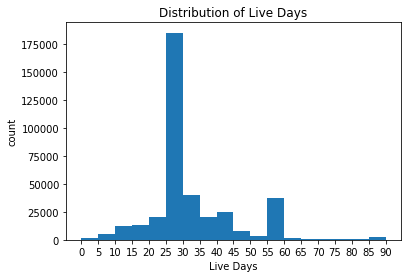

In [109]:
bin_edge = np.arange(0, 95, 5)
plt.hist(data = df, x = 'live_days', bins = bin_edge)
plt.xticks(bin_edge)
plt.xlabel('Live Days')
plt.ylabel('count')
plt.title('Distribution of Live Days');

In [110]:
df.query('live_days >= 25 and live_days <= 35').live_days.count() / len(df)

0.5977852213181102

Majority (~59.8%) of all projects were run for anywhere from 25 to 35 days; Typically lasting for about a month

### Main & Sub Category

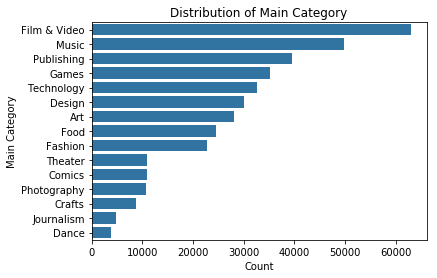

In [111]:
base_color = sb.color_palette()[0]
cat_order = df.main_cat.value_counts().index
sb.countplot(data = df, y = 'main_cat', color = base_color, order = cat_order)
plt.xlabel('Count')
plt.ylabel('Main Category')
plt.title('Distribution of Main Category');

Film & Video projects were the most created kickstarter projects, while Dance and Journalism were the least project to be created. Let's take a look at the sub-categories of Film & Video.

In [112]:
df_fnv = df.query('main_cat == "Film & Video"')

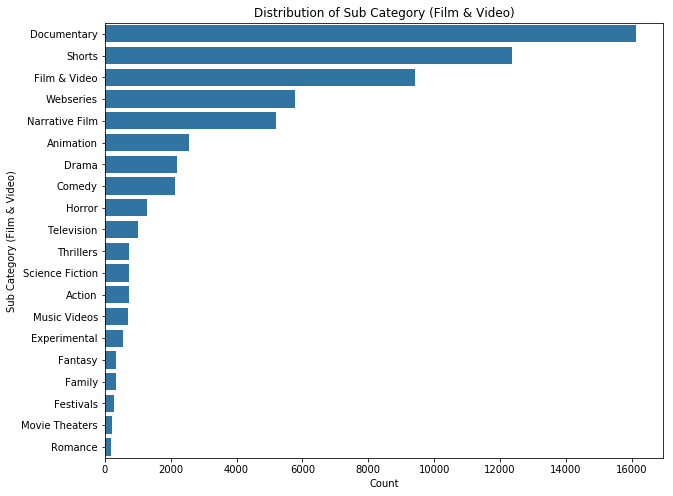

In [132]:
base_color = sb.color_palette()[0]
cat_order = df_fnv.sub_cat.value_counts().index
fig, ax = plt.subplots(figsize=(10, 8))
sb.countplot(data = df_fnv, y = 'sub_cat', color = base_color, order = cat_order)
plt.ylabel('Sub Category (Film & Video)')
plt.xlabel('Count')
plt.title('Distribution of Sub Category (Film & Video)');

Documentaries and Shorts were the most created Film & Video projects on kickstarter while Romance and Movie Theaters were the least created.

### Project State

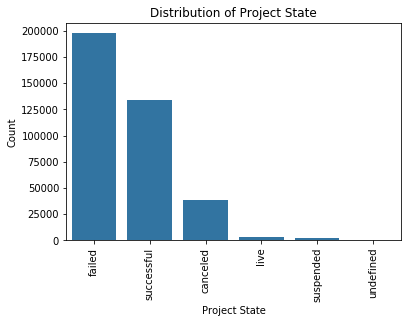

In [114]:
base_color = sb.color_palette()[0]
state_order = df.state.value_counts().index
sb.countplot(data = df, x = 'state', color = base_color, order = state_order)
plt.xlabel('Project State')
plt.ylabel('Count')
plt.title('Distribution of Project State')
plt.xticks(rotation = 90);

In [115]:
df.state.value_counts()

failed        197630
successful    133851
canceled       38763
live            2799
suspended       1842
undefined        683
Name: state, dtype: int64

As we will be performing a logistic regression on whether a project is a success or a failure, we will have to create a new boolean column stating whether a project was successful or not. Here is how we will combine projects into one of 2 groups.

* failed = 0
* successful = 1
* canceled = 0
* live (with less than 100% of goal met) = we will assume 0 for now
* live (with more then or equal to 100% of goal met) = 1
* suspended = 0
* undefined = 0

In [116]:
# initialize new column and values
df['success'] = 0

In [117]:
for i in df.index:
    
    # store project state value
    p_state = df.get_value(i, 'state')
      
    if p_state == 'successful':
        df.set_value(i, 'success', 1)
    
    if p_state == 'live':
        pct = df.get_value(i, 'goal_pct')
        
        # live projects that have already met the goal
        if pct >= 100:
            df.set_value(i, 'success', 1)
            
    # Rest of the cases will remain as 0

C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\paul.seo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


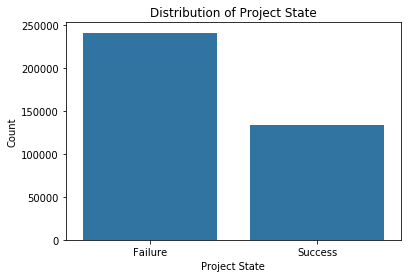

In [118]:
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'success', color = base_color)
plt.xlabel('Project State')
plt.ylabel('Count')
plt.title('Distribution of Project State')
plt.xticks(np.arange(2), ('Failure', 'Success'));

In [119]:
len(df.query('success == 1')) / len(df)

0.3575704000340817

From the findings above, approximately 36% of kickstarter projects are successful. New projects have about 1/3 of a chance in being successful on kickstarter. We will come back to this to analyze the factors that contribute to a successful project on kickstarter at the end of our analysis.

In [120]:
# reordering columns and dropping state
df = df[['name',
 'name_len',
 'main_cat',
 'sub_cat',
 'country',
 'launch_date',
 'deadline',
 'live_days',
 'backers',
 'usd_pledged',
 'usd_goal',
 'goal_pct',
 'success']]

In [121]:
df.head()

,name,name_len,main_cat,sub_cat,country,launch_date,deadline,live_days,backers,usd_pledged,usd_goal,goal_pct,success
0,The Songs of Adelaide & Abullah,31,Publishing,Poetry,GB,2015-08-11 12:12:28,2015-10-09,58.491343,0,0.0,1533.95,0.000000,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,45,Film & Video,Narrative Film,US,2017-09-02 04:43:57,2017-11-01,59.802813,15,2421.0,30000.00,8.070000,0
2,Where is Hank?,14,Film & Video,Narrative Film,US,2013-01-12 00:20:50,2013-02-26,44.985532,3,220.0,45000.00,0.488889,0
3,ToshiCapital Rekordz Needs Help to Complete Album,49,Music,Music,US,2012-03-17 03:24:11,2012-04-16,29.858206,1,1.0,5000.00,0.020000,0
4,Community Film Project: The Art of Neighborhoo...,58,Film & Video,Film & Video,US,2015-07-04 08:35:03,2015-08-29,55.642326,14,1283.0,19500.00,6.579487,0


### Project Country

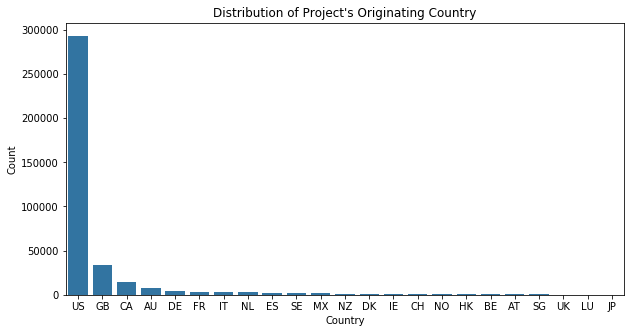

In [122]:
base_color = sb.color_palette()[0]
country_order = df.country.value_counts().index
fig, ax = plt.subplots(figsize=(10, 5))
sb.countplot(data = df, x = 'country', color = base_color, order = country_order)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Project\'s Originating Country');

In [123]:
len(df.query('country == "US"')) / len(df)

0.7804711796532185

Projects from United States of America dominate the kickstarter platform with 78% of all project until 2018 being originated from the US. Great Britain comes 2nd in number of projects and is the country with the most projects outisde of North America.

### Relationship between Project Length (Live Days) and Project Goal (USD)

array([[1.        , 0.02228962],
       [0.02228962, 1.        ]])

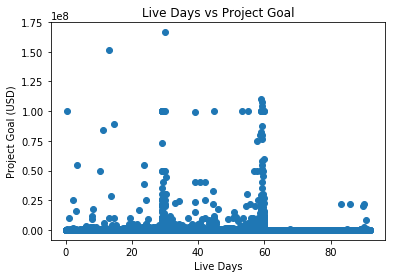

In [124]:
base_color = sb.color_palette()[0]
plt.scatter(data = df, x = 'live_days', y = 'usd_goal', color = base_color)
plt.title('Live Days vs Project Goal')
plt.xlabel('Live Days')
plt.ylabel('Project Goal (USD)');

x = df.live_days
y = df.usd_goal
np.corrcoef(x, y)

I expected these 2 variables to have a moderate to strong correlation, because both the length of the project and the funding required would directly speak of the size/scale of the proposed project. However, in reality they seem to have no relationship whatsoever.

## Exploratory Visuals - Successful Projects

Let's take a deeper look at this data by focusing on projects that were successful. What characteristics do they have? And how do they differ from when we are looking at the data as a whole?

### Live Days

In [125]:
df_s = df.query('success == 1')
df_f = df.query('success == 0')

In [126]:
s_color = sb.color_palette()[2]

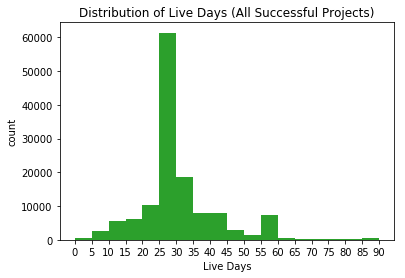

In [127]:
bin_edge = np.arange(0, 95, 5)
plt.hist(data = df_s, x = 'live_days', color = s_color, bins = bin_edge)
plt.xticks(bin_edge)
plt.xlabel('Live Days')
plt.ylabel('count')
plt.title('Distribution of Live Days (All Successful Projects)');

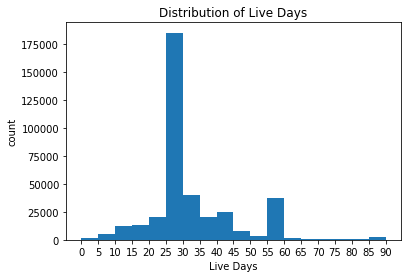

In [128]:
bin_edge = np.arange(0, 95, 5)
plt.hist(data = df, x = 'live_days', bins = bin_edge)
plt.xticks(bin_edge)
plt.xlabel('Live Days')
plt.ylabel('count')
plt.title('Distribution of Live Days');

In [129]:
len(df_s.query('live_days > 25 and live_days < 35')) / len(df_s)

0.594726417061329

The distribution of project length (live_days) is almost identical between the two. Almost 60% of all successful projects were launched on kickstarter for anywhere between 25 to 35 days (roughly 1 month)

### Main Category

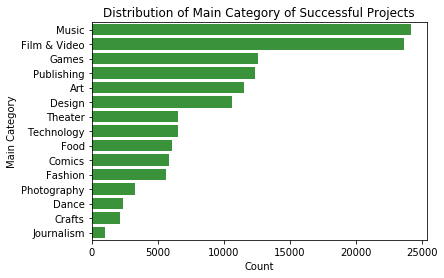

In [134]:
mc_order = df_s.main_cat.value_counts().index 
sb.countplot(data = df_s, y = 'main_cat', color = s_color, order = mc_order)
plt.title('Distribution of Main Category of Successful Projects')
plt.ylabel('Main Category')
plt.xlabel('Count');

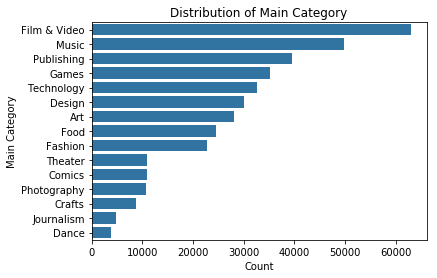

In [135]:
base_color = sb.color_palette()[0]
cat_order = df.main_cat.value_counts().index
sb.countplot(data = df, y = 'main_cat', color = base_color, order = cat_order)
plt.xlabel('Count')
plt.ylabel('Main Category')
plt.title('Distribution of Main Category');

Music is the project with the most success on Kickstarter with Film & Video coming in as a close 2nd.

### Overall Success Rate for Main Category

In [155]:
s_rate = [len(df_s.query('main_cat == "Music"')) / len(df.query('main_cat == "Music"')),
      len(df_s.query('main_cat == "Film & Video"')) / len(df.query('main_cat == "Film & Video"')),
      len(df_s.query('main_cat == "Games"')) / len(df.query('main_cat == "Games"')),
      len(df_s.query('main_cat == "Publishing"')) / len(df.query('main_cat == "Publishing"')),
      len(df_s.query('main_cat == "Art"')) / len(df.query('main_cat == "Art"')),
      len(df_s.query('main_cat == "Design"')) / len(df.query('main_cat == "Design"')),
      len(df_s.query('main_cat == "Theater"')) / len(df.query('main_cat == "Theater"')),
      len(df_s.query('main_cat == "Technology"')) / len(df.query('main_cat == "Technology"')),
      len(df_s.query('main_cat == "Food"')) / len(df.query('main_cat == "Food"')),
      len(df_s.query('main_cat == "Comics"')) / len(df.query('main_cat == "Comics"')),
      len(df_s.query('main_cat == "Fashion"')) / len(df.query('main_cat == "Fashion"')),
      len(df_s.query('main_cat == "Photography"')) / len(df.query('main_cat == "Photography"')),
      len(df_s.query('main_cat == "Dance"')) / len(df.query('main_cat == "Dance"')),
      len(df_s.query('main_cat == "Crafts"')) / len(df.query('main_cat == "Crafts"')),
      len(df_s.query('main_cat == "Journalism"')) / len(df.query('main_cat == "Journalism"'))]

main_cat = ['Music', 'Film & Video', 'Games', 'Publishing', 'Art', 'Design', 'Theater', 'Technology', 'Food', 'Comics', 'Fashion', 'Photography', 'Dance', 'Crafts', 'Journalism']

In [179]:
d = {'main_category':main_cat, 'success_rate':s_rate}
df_rate = pd.DataFrame(d)

In [16]:
df_rate.sort_values('success_rate', ascending = False, inplace = True)
df_rate.reset_index(drop = True, inplace = True)
df_rate

,main_category,success_rate
0,Dance,0.621184
1,Theater,0.599487
2,Comics,0.541825
3,Music,0.484152
4,Art,0.410323
5,Film & Video,0.375813
6,Games,0.357218
7,Design,0.353845
8,Publishing,0.311682
9,Photography,0.307478


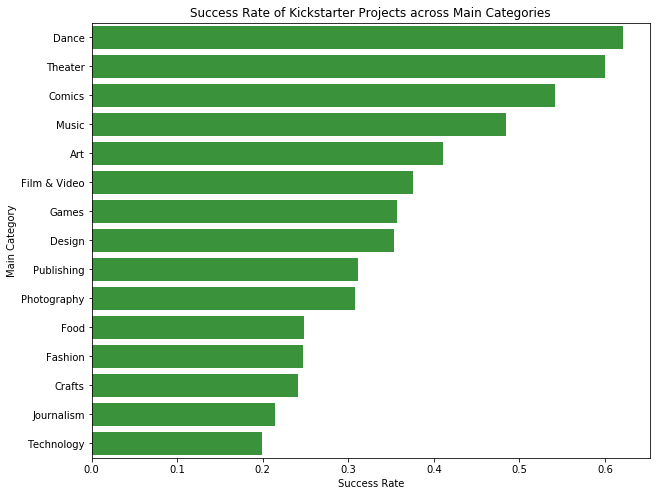

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sb.barplot(data = df_rate, x = 'success_rate', y = 'main_category', color = sb.color_palette()[2])
plt.title('Success Rate of Kickstarter Projects across Main Categories')
plt.ylabel('Main Category')
plt.xlabel('Success Rate');

Dance had the highest project success rate with 62.1% with Theather coming in as a close second with 59.9%. It should be noted that these two main categories are among the bottom 5 in the # of projects created. On a personal level, it's shocking to see that Technology kickstarter projects have a success rate below 20% as the most exposure I have had regarding kickstarter were successful gadgets that I'd randomly come across on the internet.

### Putting Main Category, Successful Projects, and Success Rate together

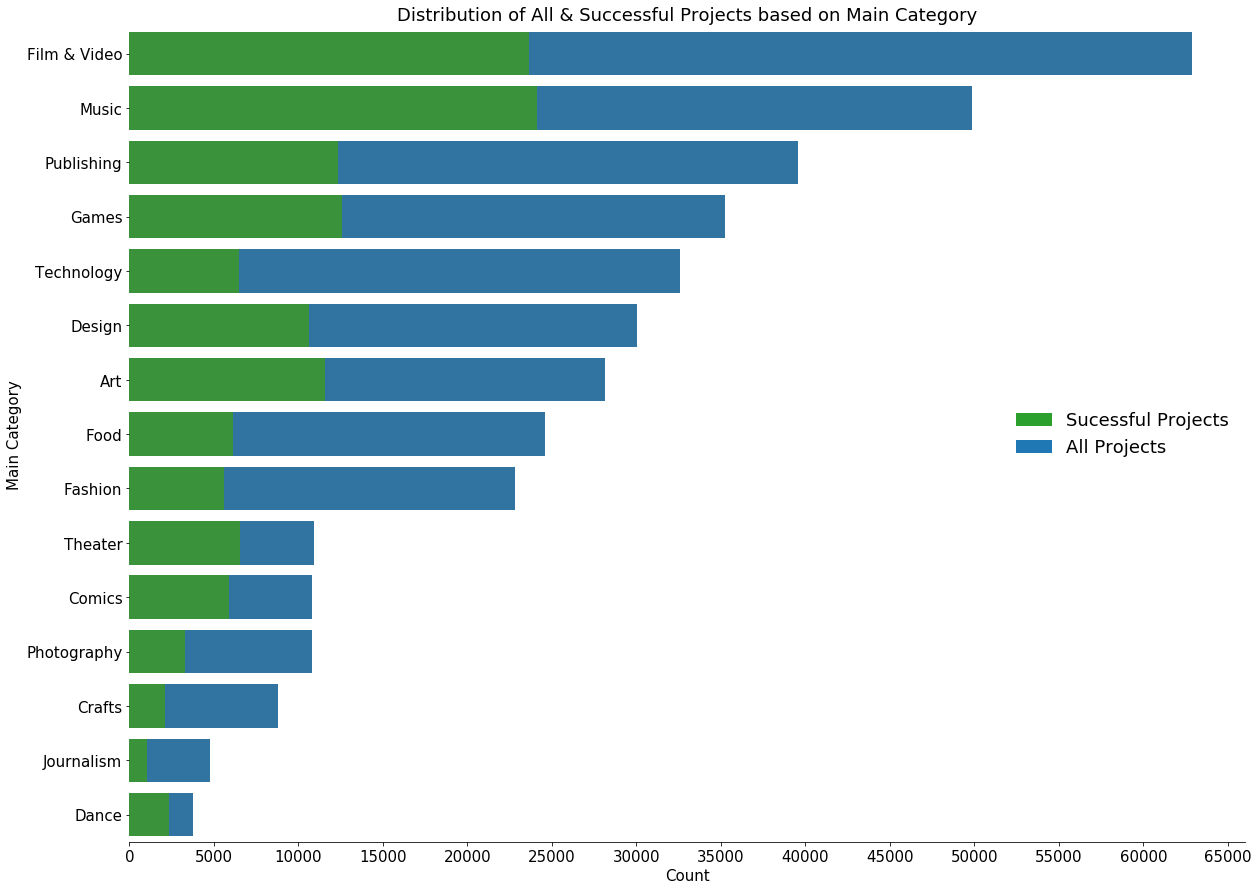

In [46]:
# defining static characteristics
blue = sb.color_palette()[0]
green = sb.color_palette()[2]
mc_order = df.main_cat.value_counts().index

# actual graph
plt.rcParams.update({'font.size': 15})
sb.set_context({"figure.figsize": (20, 15)})
sb.countplot(data = df, y = 'main_cat', color = blue, order = mc_order)
bottom_plot = sb.countplot(data = df_s, y = 'main_cat', color = green, order = mc_order)
plt.xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000])
plt.ylabel('Main Category')
plt.xlabel('Count')
plt.title('Distribution of All & Successful Projects based on Main Category')


# add legend
topbar = plt.Rectangle((0, 0), 1, 1,fc = blue, edgecolor = 'none')
bottombar = plt.Rectangle((0, 0), 1, 1, fc = green, edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Sucessful Projects', 'All Projects'], loc = 7, ncol = 1, prop={'size':18})
l.draw_frame(False)

# remove grid/box
sb.despine(left=True);

In [47]:
len(df_s.query('main_cat == "Music"'))

24134

Among the Top 5 Main Category with highest success rates (Dance, Theater, Comics, Music, Art) only Music category makes it inside Top 5 most successful projects created. In fact, Music is the number 1 in most successful projects created on Kickstarter (24,134). 

### Project Country

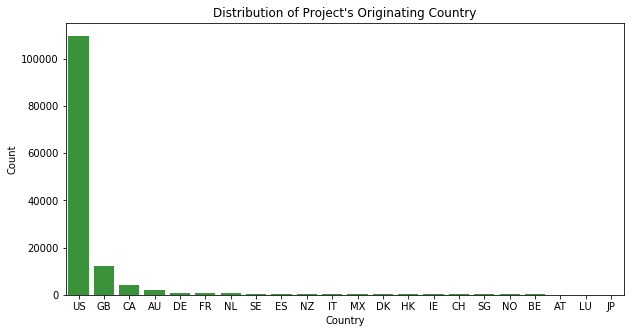

In [42]:
# resetting font size
plt.rcParams.update({'font.size': 10})

base_color = sb.color_palette()[2]
country_order = df_s.country.value_counts().index
fig, ax = plt.subplots(figsize=(10, 5))
sb.countplot(data = df_s, x = 'country', color = base_color, order = country_order)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Project\'s Originating Country');

In [43]:
# % of US projects among all successful projects
len(df_s.query('country == "US"')) / len(df_s)

0.8159160635034105

In [50]:
len(df.query('country == "US"')) / len(df)

0.7804711796532185

In [45]:
# US success rate
len(df_s.query('country == "US"')) / len(df.query('country == "US"'))

0.3738093613537118

A staggering 82% of all successful projects originated from the US. This isn't particularly surprising given that 78% of all projects have originated from the US.

## Putting it all together

I will be performing a binomial logistic regression on success. Here are the list of independent variables I will be using:
* Project Name Length (Numeric)
* Main Category (Nominal - need dummy var)
* Country (Nominal - need dummy var)
* Project live time (Numeric)
* Project Goal Amount (Numeric)

In [17]:
# Creating a df for regression
df_a = df.copy()

In [12]:
df.main_cat.value_counts().sort_index()

Art             28151
Comics          10819
Crafts           8809
Dance            3767
Design          30064
Fashion         22812
Film & Video    62901
Food            24600
Games           35225
Journalism       4754
Music           49848
Photography     10778
Publishing      39566
Technology      32563
Theater         10911
Name: main_cat, dtype: int64

In [16]:
df.country.value_counts().sort_index()

AT       599
AU      7861
BE       617
CA     14795
CH       761
DE      4183
DK      1118
ES      2282
FR      2949
GB     33671
HK       618
IE       815
IT      2884
JP        40
LU        62
MX      1752
NL      2882
NO       712
NZ      1452
SE      1761
SG       555
UK        79
US    293120
Name: country, dtype: int64

In [18]:
# Create dummy variables for Main Category and Country
df_a[['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater']] = pd.get_dummies(df_a['main_cat'])
df_a[['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 'NZ', 'SE', 'SG', 'UK', 'US']] = pd.get_dummies(df_a['country'])

In [13]:
# Create Intercept
df_a['intercept'] = 1

# Logistic Regression - BASELINE: ART + Austria
lm = sm.Logit(df_a['success'], df_a[['intercept', 'name_len', 'live_days', 'usd_goal', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 'NZ', 'SE', 'SG', 'UK', 'US']])
result = lm.fit()
result.summary()

         Current function value: 0.601180
         Iterations: 35


A:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:               375568
Model:                          Logit   Df Residuals:                   375528
Method:                           MLE   Df Model:                           39
Date:                Sat, 30 Mar 2019   Pseudo R-squ.:                 0.07795
Time:                        23:55:05   Log-Likelihood:            -2.2578e+05
converged:                      False   LL-Null:                   -2.4487e+05
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.6820      0.111     -6.158      0.000      -0.899      -0.465
name_len         0.0106      0.000     46.308      0.000       0.010       0.011
live_days       -0.0190      0.000    -63.832      0.000      -0.020      -0.018
usd_goal     -1.585e-05   2.09e-07    -75.919      0.000   -1.63e-05   -1.54e-05
Comics           0.5770      0.023     24.820      0.000       0.531       0.623
Crafts          -0.8223      0.028    -29.251      0.000      -0.877      -0.767
Dance            0.8458      0.036     23.182      0.000       0.774       0.917
Design          -0.0366      0.018     -2.060      0.039      -0.071      -0.002
Fashion         -0.6958      0.020    -34.886      0.000      -0.735      -0.657
Film & Video     0.0836      0.015      5.518      0.000       0.054       0.113
Food            -0.5580      0.020    -28.442      0.000      -0.596      -0.520
Games           -0.0214      0.017     -1.257      0.209      -0.055       0.012
Journalism      -0.8380      0.038    -21.977      0.000      -0.913      -0.763
Music            0.3286      0.015     21.265      0.000       0.298       0.359
Photography     -0.4177      0.025    -16.986      0.000      -0.466      -0.369
Publishing      -0.4180      0.017    -25.185      0.000      -0.451      -0.385
Technology      -0.6367      0.019    -33.084      0.000      -0.674      -0.599
Theater          0.7899      0.024     33.372      0.000       0.743       0.836
AU               0.2964      0.113      2.631      0.009       0.076       0.517
BE               0.3392      0.146      2.320      0.020       0.053       0.626
CA               0.3854      0.111      3.471      0.001       0.168       0.603
CH               0.5166      0.140      3.681      0.000       0.241       0.792
DE               0.1977      0.116      1.705      0.088      -0.030       0.425
DK               0.5972      0.128      4.657      0.000       0.346       0.849
ES               0.1387      0.121      1.143      0.253      -0.099       0.376
FR               0.6905      0.117      5.898      0.000       0.461       0.920
GB               0.6522      0.110      5.925      0.000       0.436       0.868
HK               0.8452      0.140      6.050      0.000       0.571       1.119
IE               0.2968      0.138      2.156      0.031       0.027       0.567
IT              -0.1895      0.122     -1.557      0.120      -0.428       0.049
JP              -0.2673      0.439     -0.609      0.542      -1.127       0.593
LU               0.7254      0.310      2.340      0.019       0.118       1.333
MX               0.0041      0.124      0.033      0.974      -0.239       0.247
NL               0.1649      0.119      1.385      0.166      -0.068       0.398
NO               0.1485      0.143      1.037      0.300      -0.132       0.429
NZ               0.5002      0.124      4.027      0.000       0.257       0.744
SE               0.4574      0.122      3.744      0.000       0.218       0.697
S

In [14]:
np.exp(result.params)

intercept       5.056033e-01
name_len        1.010686e+00
live_days       9.812144e-01
usd_goal        9.999841e-01
Comics          1.780755e+00
Crafts          4.394041e-01
Dance           2.329731e+00
Design          9.641087e-01
Fashion         4.986855e-01
Film & Video    1.087192e+00
Food            5.723749e-01
Games           9.788574e-01
Journalism      4.325783e-01
Music           1.389018e+00
Photography     6.585823e-01
Publishing      6.583559e-01
Technology      5.290472e-01
Theater         2.203086e+00
AU              1.344961e+00
BE              1.403822e+00
CA              1.470267e+00
CH              1.676277e+00
DE              1.218552e+00
DK              1.817104e+00
ES              1.148787e+00
FR              1.994712e+00
GB              1.919777e+00
HK              2.328460e+00
IE              1.345603e+00
IT              8.273982e-01
JP              7.654635e-01
LU              2.065465e+00
MX              1.004069e+00
NL              1.179309e+00
NO            

In [15]:
1/_

intercept       1.977835e+00
name_len        9.894270e-01
live_days       1.019145e+00
usd_goal        1.000016e+00
Comics          5.615594e-01
Crafts          2.275810e+00
Dance           4.292341e-01
Design          1.037227e+00
Fashion         2.005272e+00
Film & Video    9.198010e-01
Food            1.747107e+00
Games           1.021599e+00
Journalism      2.311720e+00
Music           7.199330e-01
Photography     1.518413e+00
Publishing      1.518935e+00
Technology      1.890191e+00
Theater         4.539087e-01
AU              7.435161e-01
BE              7.123413e-01
CA              6.801488e-01
CH              5.965600e-01
DE              8.206459e-01
DK              5.503263e-01
ES              8.704832e-01
FR              5.013254e-01
GB              5.208940e-01
HK              4.294684e-01
IE              7.431611e-01
IT              1.208608e+00
JP              1.306398e+00
LU              4.841524e-01
MX              9.959471e-01
NL              8.479541e-01
NO            

### Interpretation

Project Country:
* Project Success is 2.07 times as likely if it originates from the US as compared to baseline (AT), ceteris paribus
* 

Main Category:
* Project Success is 1.75 times less likely than "Art" if the main category is "Food", ceteris paribus

In [49]:
# 2019 03 26 Saving to csv
df.to_csv('temp.csv', index = False)
df_s.to_csv('temp_s.csv', index = False)
df_f.to_csv('temp_f.csv', index = False)
df_rate.to_csv('temp_rate.csv', index = False)

In [11]:
# 2019 03 28 Saving df_a to csv
df_a.to_csv('temp_a.csv', index = False)

In [2]:
# Use this to read in all dataframes
df = pd.read_csv('temp.csv')
df_s = pd.read_csv('temp_s.csv')
df_f = pd.read_csv('temp_f.csv')
df_rate = pd.read_csv('temp_rate.csv')
df_a = pd.read_csv('temp_a.csv')